# EDA ver3 : 

# **setting**

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle

#import os
#os.chdir('./data')
#os.getcwd()

In [2]:
def preprocessing_dataset(dataset):
    """처음 불러온 csv 파일을 원하는 형태의 DataFrame으로 변경 시켜줍니다."""
    subject_entity = []
    object_entity = []

    for i, j in tqdm(zip(dataset["subject_entity"], dataset["object_entity"]), desc="preprocessing"):
        i = i[1:-1].split(",")[0].split(":")[1]
        j = j[1:-1].split(",")[0].split(":")[1]

        subject_entity.append(i)
        object_entity.append(j)

    out_dataset = pd.DataFrame(
        {
            "id": dataset["id"],
            "sentence": dataset["sentence"],
            "subject_entity": subject_entity,
            "object_entity": object_entity,
            "label": dataset["label"],
        }
    )
    return out_dataset


def load_data(dataset_dir):
    """csv 파일을 경로에 맡게 불러 옵니다."""
    pd_dataset = pd.read_csv(dataset_dir)
    dataset = preprocessing_dataset(pd_dataset)

    return dataset

def label_to_num(label):
    num_label = []
    with open("/opt/ml/code/dict_label_to_num.pkl", "rb") as f:
        dict_label_to_num = pickle.load(f)
    for v in label:
        num_label.append(dict_label_to_num[v])

    return num_label

In [3]:
train_path = '/opt/ml/dataset/train/train.csv'
total_data = load_data(train_path)
# total_data.columns

preprocessing: 32470it [00:00, 381497.96it/s]


In [4]:
train_data = total_data.sample(frac=0.9, random_state=42)
val_data = total_data.drop(train_data.index)

train_label = label_to_num(train_data["label"].values)
val_label = label_to_num(val_data["label"].values)

In [5]:
train_data

,id,sentence,subject_entity,object_entity,label
2893,2893,"문하시중 이자연의 조카이고 인예왕후, 인경현비, 인절현비와는 사촌간이다.",'인절현비','이자연',per:other_family
25844,25844,"1년 후, 바이에른은 전설적인 오스트리아인 감독 에른스트 하펠이 이끄는 함부르크 S...",'에른스트 하펠','오스트리아',per:origin
17759,17759,그러다가 1949년 6월 6일 이승만 대통령과 신성모 내무부 장관의 사주를 받은 친...,'신성모','이승만',per:colleagues
10515,10515,무라트 1세의 아들 바예지드 1세는 1396년에 불가리아 북부에서 니코폴리스 전투를...,'바예지드 1세','무라트 1세',per:parents
12680,12680,실제로 남한 쪽에서는 남조선로동당·근로인민당 등 좌익계열 정당뿐 아니라 한국독립당·...,'박헌영','조선로동당',no_relation
...,...,...,...,...,...
10340,10340,오페스는 1989년 스톡홀름에서 리드 보컬리스트 다비드 이스베리가 데스 메탈 밴드로...,'오페스','스톡홀름',no_relation
23312,23312,"에도 막부는 도쿠가와 가문에 대한 충성심을 기반으로 사회 전체를 철저히 구분하였고,...",'에도 막부','도쿠가와',org:top_members/employees
22055,22055,북조는 1336년에 아시카가 다카우지가 수도였던 교토를 점령하여 고다이고 천황을 축...,'고묘 천황','고다이고 천황',no_relation
1638,1638,"김영록 전라남도지사, 이개호 농림축산식품부 장관, 이용재 도의회 의장, 이동진 진도...",'이개호','농림축산식품부',per:employee_of


# **Pre-Processing**   
### **01.Hanja preprocessing**   
> 한자 형태 바꾸기 :    
>> 㐀 -> (한자)

In [6]:
import re

In [7]:
hanja = re.compile('([一-鿕]|[㐀-䶵]|[豈-龎])+')
replace = '(한자)'
re_train_data = train_data.replace(hanja,replace)

In [8]:
#re_train_data

### **02.Eng preprocessing**  
> 영어 문자 확인하기 :   
>> 전체 데이터에서 영어 문자가 포함된 데이터 : 8973 rows   
>> subject_entitiy : 2101 rows   
>> object_entity : 2412 rows

In [9]:
def language_searching(dataset,patten):          # dataset : datafreame, patten : str
    redataset = pd.DataFrame()
    sub = pd.DataFrame()
    obj = pd.DataFrame()
    
    for ind in dataset.index:
        search_language = re.compile(patten)    # patten # 특수문자 : '([\uAC00-\uD7A30-9a-zA-Z\s])+'  // 영어 : '([A-Za-z])+'  // 한자 : '([一-鿕]|[㐀-䶵]|[豈-龎])+'
        result = search_language.findall(dataset.loc[ind]['sentence'] or dataset.loc[ind]['subject_entity'] or dataset.loc[ind]['object_entity'])
        result_sub = search_language.findall(dataset.loc[ind]['subject_entity'])
        result_obj = search_language.findall(dataset.loc[ind]['object_entity'])
        
        if result :
            redataset = redataset.append(dataset.loc[ind],ignore_index = True)
        if result_sub :
            sub = sub.append(dataset.loc[ind],ignore_index = True)
        if result_obj :
            obj = obj.append(dataset.loc[ind],ignore_index = True)
            
    return redataset,sub,obj

**영어가 포함된 데이터만 서칭**

In [10]:
patten = '([A-Za-z])+'
eng_total,eng_sub,eng_obj = language_searching(re_train_data,patten)
eng_total

,id,label,object_entity,sentence,subject_entity
0,25844.0,per:origin,'오스트리아',"1년 후, 바이에른은 전설적인 오스트리아인 감독 에른스트 하펠이 이끄는 함부르크 S...",'에른스트 하펠'
1,16401.0,org:alternate_names,'KBO',1983년 한국 프로야구(KBO)의 삼미에 입단하면서 장명부라는 등록명을 사용했다.,'한국 프로야구'
2,13741.0,org:member_of,'SK텔레콤',최남곤 유안타증권 연구원은 “지난달 30일 자로 과학기술정보통신부가 SK브로드밴드의...,'SK브로드밴드'
3,19987.0,org:top_members/employees,'구충곤',화순군(군수 구충곤)이 신종 코로나바이러스 감염증(코로나19) 장기화로 어려움을 겪...,'화순군'
4,24056.0,per:employee_of,'국민의당',"안철수 대표는 ""지난 1월 입국 기자회견에서 n번방 같은 디지털 성범죄 대책 마련을...",'안철수'
...,...,...,...,...,...
8968,24254.0,org:top_members/employees,'고한승',고한승 삼성바이오에피스 사장과 싱가포르 BIT(Bioprocessing Techno...,'삼성바이오에피스'
8969,9700.0,per:alternate_names,'Samuel Kalu',동료 사무엘 칼루(Samuel Kalu)는 긴 롱패스로 황의조 선수에게 공을 넘겼다.,'사무엘 칼루'
8970,30995.0,no_relation,'오스트레일리아',2013년 임다미는 《더 엑스 팩터 오스트레일리아》의 다섯번째 시즌 오디션에 머라이...,'임다미'
8971,29215.0,org:top_members/employees,'강인규',나주시(시장 강인규)는 6일 지역 의용소방연합회에서 설 명절을 앞두고 어려운 이웃을...,'나주시'


In [11]:
#eng_sub

In [12]:
#eng_obj

### **03. 영어 문자가 포함된 데이터 : 라벨 분포**

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
def view_count(dataset,labels : str):
    # count 분포
    view = sns.countplot(data=dataset,x=labels,order = dataset[labels].value_counts().index)
    # label명 표시
    view.set_xticklabels(view.get_xticklabels(), rotation=90)

    # 각 막대에 숫자 표시
    for p in view.patches:
        height = p.get_height()
        view.text(p.get_x() + p.get_width() / 2., height + 3, int(height), ha = 'center', size = 6.5)

    plt.show()
    return 

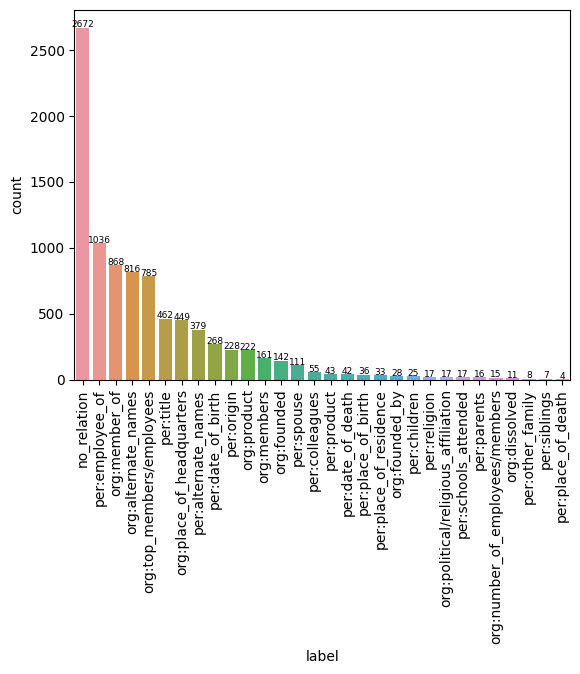

In [15]:
# dataset : eng_total
# labels : 'lable'
view_count(eng_total,'label')

**no_relation 확인하기**

In [16]:
eng_total[eng_total.label == 'no_relation']

,id,label,object_entity,sentence,subject_entity
10,19469.0,no_relation,'한국어',한국에서는 Mnet 《힛 더 스테이지》를 통해서 ‘さよならひとり (Sayonara ...,'Mnet'
14,16397.0,no_relation,'안달루시아',2008년에 시작되어 올해로 11회 째를 맞이하는 이 프로그램은 그동안 550여명의...,'말라가'
15,21311.0,no_relation,'012330',현대모비스[012330]는 기존 사이드미러 위치에 카메라 센서를 장착해 차량 내부의...,'현대모비스'
16,23292.0,no_relation,'1996',"데이비드 크리스토퍼 저스티스(David Christopher Justice, 196...",'뉴욕 양키스'
17,24269.0,no_relation,'2011년',2011년에 열린 NC 다이노스의 트라이아웃에 합격하여 신고선수로 입단하게 된다.,'NC 다이노스'
...,...,...,...,...,...
8939,18663.0,no_relation,'독일어',"그는 비엔나 종합 병원 (독일어명: ""Allgemeines Krankenhaus d...",'비엔나'
8948,29938.0,no_relation,'NGO',"한나라당은 국론분열을 야기한다며 비판하였고, 민주당 등 야당은 ""민단체의 영역인 비...",'참여연대'
8954,5827.0,no_relation,'리그 오브 레전드',2017년 5월 KT 롤스터의 입단을 통해 프로에 입문한 손우현은 리그 오브 레전드...,'KT 롤스터'
8963,4837.0,no_relation,'다마스쿠스',이에 따라 시리아군은 다마스쿠스 남동쪽 교외의 반군을 지역에 인구가 거의 없는 지역...,'시리아'


# **결과**   
- 'GS25','KT 롤스터' 등 고유명사에 해당하는 단어들이 많기 때문에 전처리하면 성능이 더 낮아질 것으로 판단됨.